<a href="https://colab.research.google.com/github/juliolunamoreno/Challenge-2.0/blob/master/CalibratedClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calibrating classifiers

Well calibrated classifiers are probabilistic classifiers for which the output of the predict_proba method can be directly interpreted as a confidence level. For instance a well calibrated (binary) classifier should classify the samples such that among the samples to which it gave a predict_proba value close to 0.8, approx. 80% actually belong to the positive class.

LogisticRegression returns well calibrated predictions as it directly optimizes log-loss. In contrast, the other methods return biased probabilities, with different biases per method:

GaussianNaiveBayes tends to push probabilities to 0 or 1 (note the counts in the histograms). This is mainly because it makes the assumption that features are conditionally independent given the class, which is not the case in this dataset which contains 2 redundant features.

RandomForestClassifier shows the opposite behavior: the histograms show peaks at approx. 0.2 and 0.9 probability, while probabilities close to 0 or 1 are very rare. An explanation for this is given by Niculescu-Mizil and Caruana [1]: “Methods such as bagging and random forests that average predictions from a base set of models can have difficulty making predictions near 0 and 1 because variance in the underlying base models will bias predictions that should be near zero or one away from these values. Because predictions are restricted to the interval [0,1], errors caused by variance tend to be one- sided near zero and one. For example, if a model should predict p = 0 for a case, the only way bagging can achieve this is if all bagged trees predict zero. If we add noise to the trees that bagging is averaging over, this noise will cause some trees to predict values larger than 0 for this case, thus moving the average prediction of the bagged ensemble away from 0. We observe this effect most strongly with random forests because the base-level trees trained with random forests have relatively high variance due to feature subsetting.” As a result, the calibration curve shows a characteristic sigmoid shape, indicating that the classifier could trust its “intuition” more and return probabilities closer to 0 or 1 typically.

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import load_dataset
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss
from scipy.stats import ks_2samp
from mlxtend.plotting import plot_decision_regions
plt.style.use('seaborn-whitegrid')

In [0]:
def Logtransformation(df,columna):
    X=df.drop(columna,axis=1)
    return (X+1).apply(np.log)

In [0]:
def Mypipeline(make_pipeline,X):
    X_pipe=make_pipeline.fit_transform(X)
    return pd.DataFrame(data=X_pipe,columns=X.columns)

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/juliolunamoreno/Data/master/dummy_data.csv',  usecols =['mean_max_cred_amount', 'sum_curr_balance', 'max_cred_lim',
                                                                                                            'mean_worst_del', 'max_worst_del', 'mean_num_paymnts_due',
                                                                                                            'mean_past_due_balnce','mean_worst_past_due_balnce','delinq_per_line',
                                                                                                            'number_revolvs', 'income', 'outcome', 'ratio', 'clase'])

In [0]:
X_log=Logtransformation(df,'clase')
X_pipe=Mypipeline(make_pipeline(StandardScaler(),MinMaxScaler()),X_log)
y=df.clase

In [0]:
pipe = make_pipeline(PCA())

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X_pipe, y, test_size = .3, random_state = 1)

In [0]:
X2D = pipe.fit_transform(X_train)

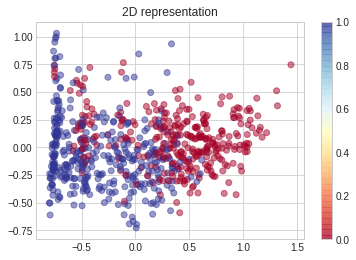

In [326]:
plt.scatter(X2D[:,0], X2D[:,1], c = y_train, cmap = 'RdYlBu', alpha = .5, facecolors = 'none')
plt.colorbar()
plt.title('2D representation');

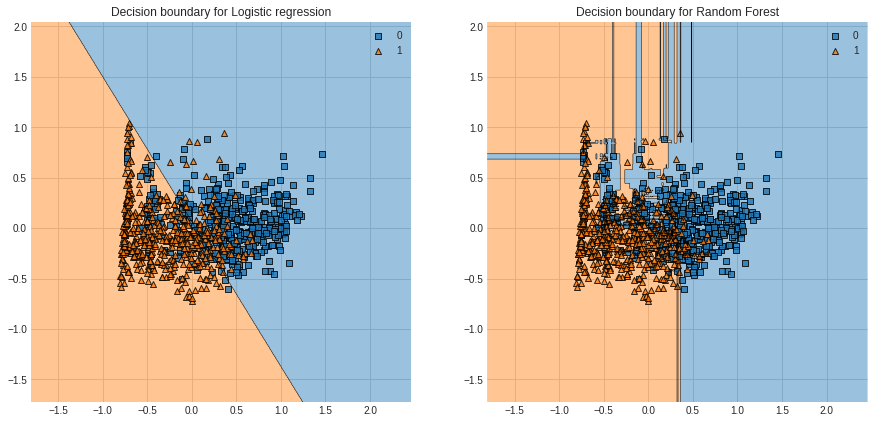

In [381]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,7))
plot_decision_regions(PCA(n_components=2).fit_transform(X_pipe), np.array(y), LogisticRegression(solver = 'lbfgs').fit(PCA(n_components=2).fit_transform(X_pipe), np.array(y)), ax = ax[0])
ax[0].set_title('Decision boundary for Logistic regression')

plot_decision_regions(PCA(n_components=2).fit_transform(X_pipe), np.array(y), RandomForestClassifier(n_estimators=10, random_state=123).fit(PCA(n_components=2).fit_transform(X_pipe), np.array(y)), ax = ax[1])
ax[1].set_title('Decision boundary for Random Forest');

In [0]:
lr = LogisticRegression(random_state=0, penalty = 'l1', class_weight = 'balanced', solver = 'liblinear' ).fit(X_train , y_train)

xgb = XGBClassifier(n_estimators=10, random_state= 0).fit(X_train, y_train)


In [0]:
lr_preds = lr.predict_proba(X_test)[:,1]

xgb_preds = xgb.predict_proba(X_test)[:,1]

In [345]:
print('TEST METRICS: \n\nLR ROC: %.3f   | XGB ROC: %.3f \n--------------------------------\nLR Brier: %.3f | XGB Brier: %.3f' % (roc_auc_score(y_true= y_test, y_score = lr_preds),
                                                                                 roc_auc_score(y_true= y_test, y_score = xgb_preds),
                                                                                 brier_score_loss(y_true = y_test, y_prob = lr_preds),
                                                                                 brier_score_loss(y_true = y_test, y_prob = xgb_preds)))

TEST METRICS: 

LR ROC: 0.935   | XGB ROC: 0.917 
--------------------------------
LR Brier: 0.102 | XGB Brier: 0.136


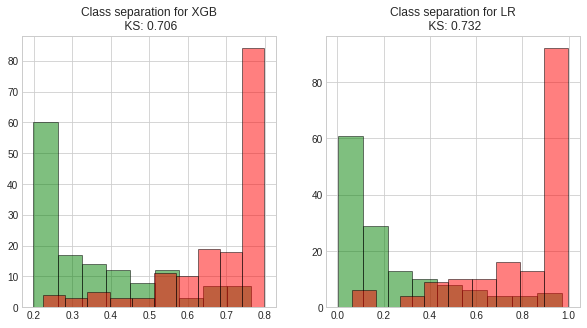

In [346]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))

ax[0].hist(xgb_preds[y_test ==0], color = 'green', alpha = .5, edgecolor = 'black',  bins = 'auto')
ax[0].hist(xgb_preds[y_test ==1],color = 'red', alpha = .5, edgecolor = 'black',  bins = 'auto')
ax[0].set_title('Class separation for XGB\n KS: %.3f' % ks_2samp(xgb_preds[y_test ==0], xgb_preds[y_test ==1])[0])

ax[1].hist(lr_preds[y_test ==0], color = 'green', alpha = .5, edgecolor = 'black',  bins = 'auto')
ax[1].hist(lr_preds[y_test ==1],color = 'red', alpha = .5, edgecolor = 'black',  bins = 'auto')
ax[1].set_title('Class separation for LR\n KS: %.3f' % ks_2samp(lr_preds[y_test ==0], lr_preds[y_test ==1])[0]);

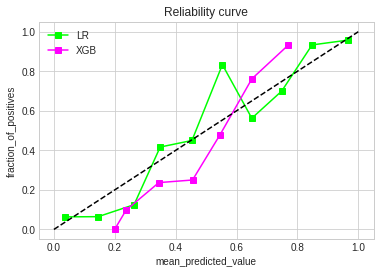

In [356]:
fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, lr_preds, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label = 'LR', color = 'lime')
fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, xgb_preds, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label = 'XGB', color = 'magenta')
plt.plot([0,1], [0,1], color = 'black', linestyle = '--')

plt.legend()
plt.xlabel('mean_predicted_value')
plt.ylabel('fraction_of_positives')
plt.title('Reliability curve');

In [0]:
Cxgb = CalibratedClassifierCV(base_estimator= XGBClassifier(n_estimators=10, random_state= 0),method='sigmoid', cv = 5).fit(X_train, y_train)

In [0]:
Cxgb_preds = Cxgb.predict_proba(X_test)[:,1]

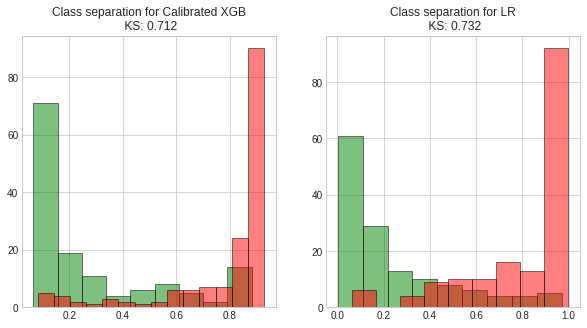

In [362]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10,5))

ax[0].hist(Cxgb_preds[y_test ==0], color = 'green', alpha = .5, edgecolor = 'black',  bins = 'auto')
ax[0].hist(Cxgb_preds[y_test ==1],color = 'red', alpha = .5, edgecolor = 'black',  bins = 'auto')
ax[0].set_title('Class separation for Calibrated XGB\n KS: %.3f' % ks_2samp(Cxgb_preds[y_test ==0], Cxgb_preds[y_test ==1])[0])

ax[1].hist(lr_preds[y_test ==0], color = 'green', alpha = .5, edgecolor = 'black',  bins = 'auto')
ax[1].hist(lr_preds[y_test ==1],color = 'red', alpha = .5, edgecolor = 'black',  bins = 'auto')
ax[1].set_title('Class separation for LR\n KS: %.3f' % ks_2samp(lr_preds[y_test ==0], lr_preds[y_test ==1])[0]);

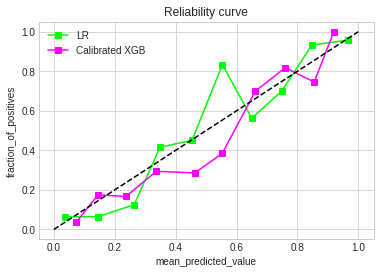

In [363]:
fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, lr_preds, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label = 'LR', color = 'lime')
fraction_of_positives, mean_predicted_value = \
        calibration_curve(y_test, Cxgb_preds, n_bins=10)
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label = 'Calibrated XGB', color = 'magenta')
plt.plot([0,1], [0,1], color = 'black', linestyle = '--')

plt.legend()
plt.xlabel('mean_predicted_value')
plt.ylabel('fraction_of_positives')
plt.title('Reliability curve');

In [364]:
print('TEST METRICS: \n\nLR ROC: %.3f   | XGB ROC: %.3f \n--------------------------------\nLR Brier: %.3f | XGB Brier: %.3f' % (roc_auc_score(y_true= y_test, y_score = lr_preds),
                                                                                 roc_auc_score(y_true= y_test, y_score = Cxgb_preds),
                                                                                 brier_score_loss(y_true = y_test, y_prob = lr_preds),
                                                                                 brier_score_loss(y_true = y_test, y_prob = Cxgb_preds)))

TEST METRICS: 

LR ROC: 0.935   | XGB ROC: 0.922 
--------------------------------
LR Brier: 0.102 | XGB Brier: 0.117
